## Projet de Python pour le data scientist (2021-2022)
## "Prédire la gravité des accidents corporels de la route"
# DUJARDIN Thomas, RONDEY Hélène, ROSUNEE Avichaï

On installe et importe les modules nécessaires.

In [13]:
#!pip install imblearn
#!pip install plotly
#!pip install haversine

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression # Regression logistique
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold #KFold répété, pour 
from sklearn.model_selection import train_test_split

In [2]:
df_accidents = pd.read_csv('caracteristiques-2019.csv', sep=";")
df_usagers = pd.read_csv('usagers-2019.csv', sep=";")
df_lieux = pd.read_csv('lieux-2019.csv', sep=";")
df_vehicules = pd.read_csv('vehicules-2019.csv', sep=";")
df_test = df_accidents.merge(df_usagers.merge(df_lieux.merge(df_vehicules)))

In [3]:
df_test

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,situ,vma,senc,catv,obs,obsm,choc,manv,motor,occutc
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,1,70,2,7,0,2,5,23,1,NaN
1,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,1,70,2,7,0,2,5,23,1,NaN
2,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,1,70,2,17,1,0,3,11,1,NaN
3,201900000002,30,11,2019,02:50,3,93,93066,1,1,...,1,70,1,7,4,0,1,0,1,NaN
4,201900000003,28,11,2019,15:15,1,92,92036,1,1,...,1,90,1,7,0,2,1,2,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132972,201900058837,27,11,2019,07:50,1,67,67482,1,1,...,1,90,1,7,0,2,1,2,1,NaN
132973,201900058838,30,11,2019,02:41,4,94,94021,1,1,...,1,90,2,7,3,0,1,21,0,NaN
132974,201900058839,30,11,2019,15:20,1,78,78640,1,1,...,1,50,2,33,0,0,7,1,1,NaN
132975,201900058840,29,11,2019,20:50,3,92,92047,1,1,...,2,110,1,10,0,2,4,0,2,NaN


In [4]:
df_test.iloc[789]
df_utiles = df_test.drop(axis=1, labels=['Num_Acc', 'com', 'adr', 'v1', 'id_vehicule', 'num_veh', 'lartpc', 'larrout', 'occutc', 'v2', 'voie'])
df_utiles = df_utiles.dropna()
df_utiles["hrmn"] = pd.to_datetime(df_utiles["hrmn"], format='%H:%S')


In [5]:
for i in df_utiles.index:
    df_utiles["hrmn"][i] = (int(df_utiles["hrmn"][i].hour))*60 + (int(df_utiles["hrmn"][i].minute))
df_utiles.dtypes

<ipython-input-5-36ffbd0d1f58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_utiles["hrmn"][i] = (int(df_utiles["hrmn"][i].hour))*60 + (int(df_utiles["hrmn"][i].minute))
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

In [6]:

df_utiles["dep"] = df_utiles["dep"].replace(["2B"], "999") #On remplace les codes des départements de la Corse par des int
df_utiles["dep"] = df_utiles["dep"].replace(["2A"], "998")
df_utiles["actp"] = df_utiles["actp"].replace(["A"], "14") #On remplace les actions du piéton non encodées par des chiffres
df_utiles["actp"] = df_utiles["actp"].replace(["B"], "15")
df_utiles["dep"] = df_utiles["dep"].astype('int64')
df_utiles["presence_deces"] = 0
df_utiles.to_csv('df_utiles.csv')

In [7]:
df_utiles["hrmn"] = df_utiles["hrmn"].astype('int64')

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Timestamp'

In [8]:
for i in df_utiles.index:
    if df_utiles["grav"][i] == 2:
        df_utiles["presence_deces"][i] = 1

<ipython-input-8-46231476fb6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_utiles["presence_deces"][i] = 1


In [9]:
df_utiles.head(12478)

,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,...,situ,vma,senc,catv,obs,obsm,choc,manv,motor,presence_deces
0,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,7,0,2,5,23,1,0
1,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,7,0,2,5,23,1,0
2,30,11,2019,60,4,93,1,1,1,2,...,1,70,2,17,1,0,3,11,1,0
3,30,11,2019,120,3,93,1,1,1,6,...,1,70,1,7,4,0,1,0,1,0
4,28,11,2019,900,1,92,1,1,1,4,...,1,90,1,7,0,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12473,20,12,2019,540,1,84,2,1,3,6,...,1,50,3,7,0,1,1,2,1,0
12474,17,12,2019,1080,5,62,2,1,2,6,...,1,50,1,7,0,1,1,26,1,0
12475,17,12,2019,1080,5,62,2,1,2,6,...,1,50,1,7,0,1,1,26,1,0
12476,6,11,2019,480,1,6,2,1,1,6,...,1,50,1,7,0,1,1,15,1,1


## Partie carte

## Partie prédiction

In [10]:
X = df_utiles.iloc[:, :40]
y = df_utiles.iloc[:, 39:]
y = y.astype(int)
os = SMOTE(random_state=0) # Pour avoir 50 % de 0 et 50 % de 1 dans la colonne presence_incendie
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
X_train,y_train=os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=X_train,columns=columns )
y_train= pd.DataFrame(data=y_train,columns=['presence_deces'])
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(y_pred)
print(logreg.coef_)
print('Précision de la classification par régression logistique : ',logreg.score(X_test, y_test)*100,"%")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(X_test)

ValueError: y should be a 1d array, got an array of shape (88652, 5) instead.

#Partie ARIMA (expliquer le sens)

In [11]:
# ARIMA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


[263 239 255 298 287 206 288 335 355 317 450 301 264 356 357 338 347 473
 345 230 330 275 257 313 337 327 226 276 299 318 313 427 288 250 304 294
 326 405 431 326 298 282 346 351 374 491 437 328 305 307 299 337 401 342
 275 367 366 323 311 308 257 251 259 309 304 346 343 303 290 295 299 305
 320 362 352 279 350 334 315 388 479 438 284 324 373 397 367 455 404 428
 302 365 324 435 415 355 285 313 306 376 355 422 419 312 284 319 373 382
 457 415 274 289 308 311 312 417 285 273 291 366 325 390 299 277 288 338
 367 279 297 406 325 321 430 423 395 339 353 308 274 307 292 387 363 421
 394 358 345 347 419 353 420 423 400 329 371 411 383 457 393 374 251 391
 412 368 441 382 451 424 403 367 394 571 453 388 436 397 445 442 540 469
 467 431 483 477 535 527 473 430 373 445 428 407 483 415 380 391 406 423
 365 432 443 336 288 341 376 385 415 393 249 354 362 289 353 444 323 303
 349 321 354 311 416 339 305 270 335 316 220 314 381 342 270 295 280 340
 347 368 384 295 291 302 400 430 459 312 343 370 37

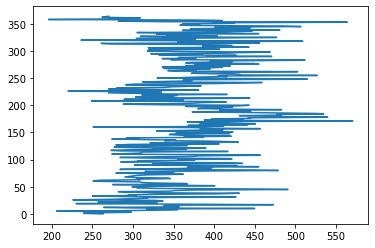

In [12]:
%matplotlib inline
from datetime import date
df_utiles = pd.read_csv('df_utiles.csv')
df_utiles["gigajour"] = 0
df_utiles["gigajour"] = df_utiles["jour"].astype(str)+'/'+df_utiles["mois"].astype(str)+'/'+df_utiles["an"].astype(str)
df_utiles["gigajour"] = pd.to_datetime(df_utiles["gigajour"], format="%d/%m/%Y")
df_utiles["colonne_soustraction"] = date(df_utiles["an"].iloc[0], 1, 1)
df_utiles["colonne_soustraction"] = pd.to_datetime(df_utiles["colonne_soustraction"])
df_utiles["nbre_j"] = df_utiles["gigajour"] - df_utiles["colonne_soustraction"]
def datification(x):
    return x.days
df_utiles["nbre_j"] = df_utiles["nbre_j"].apply(datification)
nbre_acc_j = df_utiles.groupby(['nbre_j']).agg('count').jour.values
print(nbre_acc_j)
ts = pd.Series(nbre_acc_j, index=pd.date_range("1/1/2019", periods=365))
print(ts)
plt.plot(nbre_acc_j, [i for i in range(365)])
plt.savefig('test.png')